<a href="https://colab.research.google.com/github/raspopovaa/Pet-Project-Data-Analyst/blob/main/%D0%98%D1%81%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BE%D0%B1%D1%8A%D1%8F%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D0%B9_%D0%BE_%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B6%D0%B5_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D1%80%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

Импортируем бнеобходимые библиотеки

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime, time
import numpy as np
import seaborn as sn
import pandas as pd

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
pd.set_option('display.max_rows', None)

Импортируем таблицу, выводим на экран первые несколько строк. Изучаем данные.

In [5]:

data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

In [6]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.000,108.000,2019-03-07T00:00:00,3,2.700,16.000,51.000,8,NaN,False,False,25.000,nan,Санкт-Петербург,18863.000,16028.000,1.000,482.000,2.000,755.000,nan
1,7,3350000.000,40.400,2018-12-04T00:00:00,1,nan,11.000,18.600,1,NaN,False,False,11.000,2.000,посёлок Шушары,12817.000,18603.000,0.000,nan,0.000,nan,81.000
2,10,5196000.000,56.000,2015-08-20T00:00:00,2,nan,5.000,34.300,4,NaN,False,False,8.300,0.000,Санкт-Петербург,21741.000,13933.000,1.000,90.000,2.000,574.000,558.000
3,0,64900000.000,159.000,2015-07-24T00:00:00,3,nan,14.000,nan,9,NaN,False,False,nan,0.000,Санкт-Петербург,28098.000,6800.000,2.000,84.000,3.000,234.000,424.000
4,2,10000000.000,100.000,2018-06-19T00:00:00,2,3.030,14.000,32.000,13,NaN,False,False,41.000,nan,Санкт-Петербург,31856.000,8098.000,2.000,112.000,1.000,48.000,121.000


Визуально оценим данные из таблицы. Есть много пропусков в разных столбцах. Название столбца cityCenters_nearest, написано в разных регистрах и без нижнего подчеркивания между словами. Изменим его. Еще в двух столбцах добавим нижнее подчеркивание.

In [7]:
data.rename(columns={'cityCenters_nearest': 'city_centers_nearest', 'ponds_around3000': 'ponds_around_3000', 'parks_around3000': 'parks_around_3000'}, inplace=True)

Посмотрим краткую инфармацию о таблице.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Посмотрим не процет пропусков в таблице.

In [9]:
pd.DataFrame(round((data.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.360000
living_area,8.030000
floor,0.000000
is_apartment,88.290000


### Вывод

Использовав метод info и head, можно сделать вывод, что таблица содержит 23699 строк, 22 столбца. Столбцы имеют разный тип данных. Таблица удобная для анализа данных - в каждом столбце хранятся значения, каждая строка содержит одно наблюдение, к которому привязаны значения разных переменных. Название столбцов без пробелов, несколько слов разделяются нижним подчеркиванием, на одном языке и в одном регистре, отображают в краткой форме какого рода информация содержится в каждом столбце. Наблюдаем огромное количество пропусков в 14 столбцах из 22. Особенно в столбце is_apartment 88% значений - пропуски. Так же видим много пропусков в столбцах ponds_nearest, balcony и parks_nearest. Пропуски есть в большинстве столбцов и в большом количестве. Таблица имеет два типа данных. Первый - данные заполненые самими людьми. В них прричина пропусков - человеческий фактор. Люди не знали, как заполнить соответствующее поле, поэтому нам придется заполнить эти поля за них. Второй тип данных - картографические данные которые были заполнены автоматически, в них тоже есть пропуски - это технические пропуски. По данным пропускам можно сформировать Баг-репорт, для дальнейшего исправления разработчиками. Целесообразно заполнить пропуски с первым типом данных. 
Необходимо провести предобработку данных, для выявления артефактов содержащих недостоверные данные и исключить пропуски.


## Предобработка данных

In [10]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment             object
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
city_centers_nearest    float64
parks_around_3000       float64
parks_nearest           float64
ponds_around_3000       float64
ponds_nearest           float64
days_exposition         float64
dtype: object

Переведм столбец first_day_exposition из строкового типа в дату и время

In [11]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')


Проверим, что получилось.

In [12]:
data['first_day_exposition'].dtypes

dtype('<M8[ns]')

Округлим дату до дня. Уберем лишние часы и минуты. В любом случае там были только нулевые значения.

In [13]:
data['first_day_exposition'] = data['first_day_exposition'].dt.round('1D')

In [14]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000.000,108.000,2019-03-07,3,2.700,16.000,51.000,8,NaN,False,False,25.000,nan,Санкт-Петербург,18863.000,16028.000,1.000,482.000,2.000,755.000,nan
1,7,3350000.000,40.400,2018-12-04,1,nan,11.000,18.600,1,NaN,False,False,11.000,2.000,посёлок Шушары,12817.000,18603.000,0.000,nan,0.000,nan,81.000
2,10,5196000.000,56.000,2015-08-20,2,nan,5.000,34.300,4,NaN,False,False,8.300,0.000,Санкт-Петербург,21741.000,13933.000,1.000,90.000,2.000,574.000,558.000
3,0,64900000.000,159.000,2015-07-24,3,nan,14.000,nan,9,NaN,False,False,nan,0.000,Санкт-Петербург,28098.000,6800.000,2.000,84.000,3.000,234.000,424.000
4,2,10000000.000,100.000,2018-06-19,2,3.030,14.000,32.000,13,NaN,False,False,41.000,nan,Санкт-Петербург,31856.000,8098.000,2.000,112.000,1.000,48.000,121.000



Так как в столбце ceiling_height доля пропущенных значений очень большая -38%, более умесным будет на трогать эти пропуски и оставить все как есть. 

In [15]:
data['ceiling_height'].value_counts(bins=4)

(0.9, 25.75]      14491
(25.75, 50.5]        12
(75.25, 100.0]        1
(50.5, 75.25]         0
Name: ceiling_height, dtype: int64

Много пропусков. Есть значения явно недостоверные, к примеру высота потолка 100 метров или 1 метр. Придумаем чем можно заменить. Нужна фунция которая будет заменять не только пропущенные значения но и те которые мы укажем. Допустим высота или потолков зависит от элитности. Параметра элитное у нас нет будет ориентироваться на цены.  Заменим пропуски на медиану высоты потолков в конкретной ценовой категории.

Создаем копию таблицы

In [16]:
t = data.copy()

Сгруппируем цену на 5 почти равных частей. Разделим на равные части методом qcut

In [17]:
t['last_price_group'] = pd.qcut(t['last_price'], 5, labels=["эконом", "средний", "бизнес", "элитное", "чтоб я так жил",])
t['last_price_group'].value_counts()

эконом            4756
бизнес            4741
чтоб я так жил    4739
элитное           4739
средний           4724
Name: last_price_group, dtype: int64

Напишем функцию которая автоматически меняет пропуски на медиану той же категории значений.

In [18]:

def no_NaN(df, value, category):
    for type_unique in df[category].unique():
        df.loc[(df[value].isna())&(df[category] ==type_unique), value] = \
        df.loc[df[category] ==type_unique, value].median()
    return df
   
        

Применим фунцию и проверим результат.

Теперь напишем фунцию которая будет менять артефакты. Например: высота потолков - 1 метр и 100 метров.

In [19]:
def no_artefact(df, value, category, min_num, max_num):
    for type_unique in df[category].unique():
        df.loc[(df[value] > max_num) | (df[value] <= min_num)&(df[category] ==type_unique), value] = \
        df.loc[df[category] ==type_unique, value].median()
        
    return df

Следующий столбец - floors_total смотрим.

In [20]:
len(data.loc[data['floors_total'].isna()])

86

Всего 86 значений. Думаю можно удалить. Так же оставшиеся значения заменим на целочисленные. 

In [21]:
data.dropna(subset = ['floors_total'], inplace = True)
data['floors_total'] = data['floors_total'].astype('int')

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  float64       
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        14495 non-null  float64       
 6   floors_total          23613 non-null  int64         
 7   living_area           21743 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          21382 non-null  float64       
 13  balcony         

Далее по списку - living_area. Посмотрим на пропуски.

In [23]:
data.loc[data['living_area'].isna(), ].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
3,0,64900000.000,159.000,2015-07-24,3,nan,14,nan,9,NaN,False,False,nan,0.000,Санкт-Петербург,28098.000,6800.000,2.000,84.000,3.000,234.000,424.000
7,5,7915000.000,71.600,2019-04-18,2,nan,24,nan,22,NaN,False,False,18.900,2.000,Санкт-Петербург,23982.000,11634.000,0.000,nan,0.000,nan,nan
30,12,2200000.000,32.800,2018-02-19,1,nan,9,nan,2,NaN,False,False,nan,nan,Коммунар,nan,nan,nan,nan,nan,nan,63.000
37,10,1990000.000,45.800,2017-10-28,2,2.500,5,nan,1,NaN,False,False,nan,nan,поселок городского типа Красный Бор,nan,nan,nan,nan,nan,nan,196.000
44,13,5350000.000,40.000,2018-11-18,1,nan,22,nan,3,NaN,False,False,nan,1.000,Санкт-Петербург,30471.000,11603.000,1.000,620.000,1.000,1152.000,nan


Поступаем аналогично и применим написанную выше функцию no_NAN. Для этого сгруппируем данные.

In [24]:
data['total_area_group'] = pd.qcut(data['total_area'], 5, labels=["студия", "не большие", "средние", "большие", "очень большие",])
data['total_area_group'].value_counts()

не большие       4962
студия           4733
очень большие    4720
большие          4635
средние          4563
Name: total_area_group, dtype: int64

Применяем фунцию - проверяем результат.

In [25]:
data = no_NaN(data, 'living_area', 'total_area_group')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  float64       
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        14495 non-null  float64       
 6   floors_total          23613 non-null  int64         
 7   living_area           23613 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          21382 non-null  float64       
 13  balcony         

In [26]:
data['living_area'].value_counts(bins=4)

(1.5910000000000002, 103.925]    23297
(103.925, 205.85]                  286
(205.85, 307.775]                   24
(307.775, 409.7]                     6
Name: living_area, dtype: int64

Так же применяем фунцию no_artefact для замены недостоверных данных. А именно удаляем минимальные значения (1,5 метра - скорее всего не реальное значение). Ограничивать максимальные значения не целесообразно.

In [27]:
data = no_artefact(data, 'living_area', 'total_area_group', 10, 5000)
data['living_area'].value_counts(bins=4)

(9.679, 109.985]     23342
(109.985, 209.89]      241
(209.89, 309.795]       24
(309.795, 409.7]         6
Name: living_area, dtype: int64

     
 Следующий столбец - is_apartment. В данном столбце 88 % пропуском. Думаю достоверно заменить такое количество невозможно. Оставим данные как есть.       

Продолжаем. Следующий столбец - 'kitchen_area' заполняем с помощью функции.

In [28]:
data = no_NaN(data, 'kitchen_area', 'total_area_group')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  float64       
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        14495 non-null  float64       
 6   floors_total          23613 non-null  int64         
 7   living_area           23613 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          23613 non-null  float64       
 13  balcony         

Если человек не указал количество балконов логично предположить, что их нет. В столбце balcony пропуски заменяем на 0. И меняем тип данных на целочисленный.

In [29]:
data['balcony'] = data['balcony'].fillna(0).astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  float64       
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        14495 non-null  float64       
 6   floors_total          23613 non-null  int64         
 7   living_area           23613 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          23613 non-null  float64       
 13  balcony         

Столбец locality_name.

In [30]:
len(data[data['locality_name'].isna()])


48

Всего 48 значений. Удаляем. И заодно приведем вид наименования населенного пункта к единообразию.  Так же заменим букву ё на е, для уменьшения дублей.

In [31]:
data.dropna(subset=['locality_name'], inplace=True)
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        14481 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          2760 non-null   object        
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

        
 Столбец 'days_exposition' имеет слишком много пропусков. Оставим его без именений.

### Вывод


В данной таблице было множество пропусков, в большинстве столбцов. Таблицу можно разделить на два типа данных - заполненых пользователями и картографические данные заполненые автомачитески. Считаю умесным заполнить только пропуски в данных заполненых пользователями, так как именно эти данные будут играть большую роль в определении рыночной цены недвижомости. Картографические данные так же важны, но достоверно заменить пропуски в них будет проблематично, так как дынные отсутсвуют по всему населенному пункту, следовательно заменить их на подобное значение в соответсвующей группе не получиться. По данному вопросу нужно создать баг-репорт и обратиться к разработчикам  для исправления данных. Нам же будет достаточнои тех что остались заполеными. Основной населенный пунк Санкт-петербург заполнен. Начнём наше исследование, данных для него достаточно.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Андрей, ты предложил определенные стратегии заполнения пропусков в данных, основанные на биннинге, в целом, это интересное решение, но хочу напомнить о том, что важно понимать риски тех способов, которые ты используешь для обработки пропусков.
    
Например, не совсем корректно заменять пропуски в ceiling_height на среднее или медианное значение потолков (это же касается моды). В этой колонке отсутствует около 38% данных. Это очень много, и сложно найти веские причины для таких радикальных трансформаций. А в случае замены на конкретное значение без ссылки на источники - это, скорее, искажение исходных данных, а не их обогащение. По поводу того, насколько биннинг здесь может отработать корректно с точки зрения рисков искажения данных - вопрос дискуссионный.
    
Такая стратегия удачна для переменных, в которых отсутствует до 10% данных.

Зачем мы вообще проводим EDA? Есть два пункта:
1. Мы хотим получить какие-то инсайты о данных (средние значения, минимумы, максимумы и т.д.), чтобы описать, например, среднестатистическую продаваемую квартиру.
2. Мы хотим проверить, подходят ли данные для моделирования (смотрим на аномалии, распределения переменных и другие характеристики) — об этом ты узнаешь в последующих уроках🙌
    
Соответственно, мы должны быть очень осторожны с изменением изначальных данных. Трансформации с булевыми переменными не должны сильно повлиять на наши будущие интерпретации, так как логика замены очень сильная: если нет положительного ответа, значит, он отрицательный. (так, например, в случае is_apartment можно предположить бинарную природу этих данных, в изначальном виде там как раз содержались значения True и False, но в целом согласна, что опять же процент пропусков большой и мы точно не знаем, является ли NaN, например, False. Удалить данные столбец тоже решение дискуссионное, если он не используется в анализе, наверно, можно попробовать просто не трогать эти данные) Но все остальные преобразования — под вопросом, поскольку это искусственная замена.

Также в этих данных есть картографические данные (расстояние до парков и проч), эти данные тоже не совсем продуктивно восполнять, потому что процент пропусков слишком большой, наверняка эти данные заполнялись автоматически, поэтому сложно восстановить их каким-то известным способом, я бы не рекомендовала заполнять пропуски в этих колонках.

    
Конечно, последнее слово всегда за аналитиком, но в реальной жизни важно понимать вероятность того, что объективность данных может быть искажена подобными. Чтобы доказать обратное, можно, например, сравнить распределения и ключевые статистики до и после замены.
    
Хочу посоветовать тебе статью, которая рассматривает разные способы обработки пропусков, выделяет их плюсы и минусы, думаю, тебе может быть интересно: https://loginom.ru/blog/missing
    
Какие стратегии замены были бы наименее "болезненными" и  "искажающими"? Можно попробовать заполнить пропуски по группировкам (ты опять де использовал по сути разновидность граппировки - бинниг и замену на медиану по группе). Или построить корреляционную матрицу, посмотреть, какие переменные коррелируют между собой, и на основе корреляции и группировки заполнить пропуски. Но при этом опять-таки важно оценивать масштаб проблемы, и применять любые стратегии заполнения только там, где это действительно уместно и возможно, как и сказано в инструкции к проекту.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
        
Хорошо, что ты обратил внимание на колонку с названиями населенных пунктов и попытался обработать значения в ней.
        
Я бы также на этапе предобработки данных в этой колонке порекомендовала попробовать поменять букву ё на е. Это также поможет избавиться от неявных дубликатов. В этом тебе поможет метод `str.replace()`

<div class="alert alert-info">
    <h2> Комментарий студента <a class="tocSkip"> </h2>
    
        
Спасибо большое за такое развёрнутое замечание. Я уверен, что в будущем мне эта информация пригодится. Из вышесказанного я сделал следующий краткий вывод - столбцы с долей пропусков больше 10 % лучше нетрогать (можем испортить данные), а если очень надо, то делаем это осторожно, учитвая индивидуальные особенности данных. 

<div class="alert alert-success">
<h2> Комментарий ревьюера: вторая итерация ревью <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Да, абсолютно верно! Работа с пропусками, с моей точки зрения,одна из самых сложных задач в работе аналитика, потому что в большинстве, если не во всех сферах, искажение данных может привести к не самым благоприятным последствиям, и аналитику в этом смысле приходится принимать решения и брать на себя ответственность. Есть ряд техник по заполнению пропусков, не считаю логических восполнений, да, с ними надо быть осторожными и стараться по возможности восполнять данные не самостоятельно, а с применением источника, если он доступен.

## Расчёты и добавление результатов в таблицу

Расчитаем цену квадратного метра.

In [32]:
data['sqmetr_price'] = data['last_price'] / data['total_area']

In [33]:
data.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,total_area_group,sqmetr_price
4330,6,4250000.000,55.100,2017-05-16,3,2.600,5,41.000,3,NaN,False,False,5.500,0,санкт-петербург,18792.000,13755.000,0.000,nan,0.000,nan,179.000,средние,77132.486
12875,1,4421650.000,41.530,2014-12-04,1,nan,25,17.340,1,NaN,False,False,9.670,0,санкт-петербург,43254.000,12012.000,0.000,nan,0.000,nan,911.000,не большие,106468.818
4742,14,2995000.000,40.400,2018-10-22,1,nan,10,18.600,4,NaN,False,False,10.780,1,деревня кальтино,nan,nan,nan,nan,nan,nan,94.000,не большие,74133.663
6301,13,4950000.000,42.000,2017-05-05,1,2.780,16,20.200,16,NaN,False,False,12.400,2,санкт-петербург,44881.000,17385.000,1.000,192.000,0.000,nan,252.000,не большие,117857.143
958,18,6500000.000,72.000,2019-04-15,3,2.600,12,48.000,1,NaN,False,False,7.200,0,санкт-петербург,32066.000,12658.000,0.000,nan,0.000,nan,nan,большие,90277.778


Узнаем день недели, месяц и год подачи объявления.

In [34]:
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday
data['month_exposition']= pd.DatetimeIndex(data['first_day_exposition']).month
data['year_exposition']= pd.DatetimeIndex(data['first_day_exposition']).year

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"></h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
    
Библиотека `pandas` позволяет решить задачу по выделению названий дней недели и месяцев в более удобном формате: например, есть такой метод как `day_name()` и `month_day()`, которые автоматически добавляют названия дней и месяцев (на английском языке по умолчанию)
    
    
https://www.geeksforgeeks.org/python-pandas-series-dt-day_name/
    
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.day_name.html
    
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.month_name.html
    
https://www.geeksforgeeks.org/python-pandas-series-dt-month_name/
        
Ты использовал корректные методы, эти в качестве альтернативы.

In [35]:
data.sample(5)


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,total_area_group,sqmetr_price,weekday_exposition,month_exposition,year_exposition
2085,12,3900000.000,40.000,2017-08-31,1,nan,17,20.200,16,NaN,False,False,9.000,0,санкт-петербург,39622.000,14906.000,0.000,nan,0.000,nan,44.000,не большие,97500.000,3,8,2017
12199,13,10250000.000,82.000,2017-02-03,3,3.950,3,54.000,2,NaN,False,False,11.000,0,санкт-петербург,22107.000,4894.000,1.000,204.000,0.000,nan,nan,очень большие,125000.000,4,2,2017
1219,11,3700000.000,39.000,2017-11-10,1,2.650,12,20.000,8,NaN,False,False,8.000,0,санкт-петербург,35449.000,15751.000,1.000,811.000,3.000,559.000,117.000,не большие,94871.795,4,11,2017
14407,11,1400000.000,36.000,2019-04-16,1,2.500,5,18.000,4,NaN,False,False,9.000,0,деревня сяськелево,nan,nan,nan,nan,nan,nan,nan,студия,38888.889,1,4,2019
3618,16,4000000.000,75.030,2014-12-15,2,2.530,3,66.220,3,NaN,False,False,14.000,0,всеволожск,nan,nan,nan,nan,nan,nan,588.000,очень большие,53312.009,0,12,2014


Переименуем название этажей на первый, последний и другие. Для этого создадим функцию name_floors.

In [36]:
def name_floors(row):
    floor = row['floor']
    floors_total= row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    elif floor !=1 and floor != floors_total:
        return 'другой'
    else:
        return 'нужно проверить'

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Здорово, что ты используешь свою функцию для категоризации данных в этом столбце, это хорошая практика программирования.

In [37]:
data['name_floor'] = data.apply(name_floors, axis=1)
data.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,total_area_group,sqmetr_price,weekday_exposition,month_exposition,year_exposition,name_floor
1557,8,3620000.000,33.500,2016-06-28,1,nan,16,17.100,6,NaN,False,False,9.300,0,санкт-петербург,41935.000,9551.000,0.000,nan,0.000,nan,205.000,студия,108059.701,1,6,2016,другой
7564,16,8580000.000,68.700,2018-08-29,2,2.800,25,41.600,20,NaN,False,False,12.400,0,санкт-петербург,28841.000,11062.000,1.000,494.000,1.000,527.000,130.000,большие,124890.830,2,8,2018,другой
8909,2,6100000.000,77.900,2018-07-25,3,2.750,20,48.880,8,NaN,False,False,12.020,0,поселок мурино,nan,nan,nan,nan,nan,nan,29.000,очень большие,78305.520,2,7,2018,другой
8363,13,5690000.000,41.700,2016-12-29,2,3.200,5,23.000,2,NaN,False,False,7.500,0,санкт-петербург,23963.000,3530.000,2.000,352.000,3.000,341.000,283.000,не большие,136450.839,3,12,2016,другой
12569,13,5350000.000,50.000,2018-08-08,2,2.550,12,27.800,10,NaN,False,False,7.600,1,санкт-петербург,12148.000,11195.000,0.000,nan,1.000,427.000,80.000,средние,107000.000,2,8,2018,другой


Найдем соотношение жилой и общей площади, а также отношение площади кухни к общей. Создадим соответствующие столбцы.

In [38]:
data['living_area_%'] = data['living_area'] / data['total_area']*100
data['kitchen_area_%'] = data['kitchen_area'] / data['total_area']*100
data.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,total_area_group,sqmetr_price,weekday_exposition,month_exposition,year_exposition,name_floor,living_area_%,kitchen_area_%
10784,3,4800000.000,57.000,2016-02-12,3,nan,9,38.000,1,NaN,False,False,7.500,0,санкт-петербург,44800.000,17039.000,0.000,nan,0.000,nan,151.000,средние,84210.526,4,2,2016,первый,66.667,13.158
17235,14,5700000.000,56.500,2017-04-25,2,2.550,4,38.000,2,NaN,False,False,7.100,0,санкт-петербург,24070.000,3902.000,0.000,nan,0.000,nan,292.000,средние,100884.956,1,4,2017,другой,67.257,12.566
1432,19,7500000.000,82.000,2016-03-21,3,3.100,5,50.000,3,False,False,False,11.000,0,санкт-петербург,31113.000,4092.000,1.000,76.000,3.000,362.000,124.000,очень большие,91463.415,0,3,2016,другой,60.976,13.415
21538,0,7300000.000,62.400,2018-09-17,2,2.700,16,33.000,8,NaN,False,False,18.000,0,санкт-петербург,30571.000,11470.000,1.000,721.000,0.000,nan,147.000,большие,116987.179,0,9,2018,другой,52.885,28.846
21668,9,4500000.000,34.300,2019-03-04,1,nan,9,17.500,3,NaN,False,False,8.900,1,санкт-петербург,nan,nan,nan,nan,nan,nan,nan,студия,131195.335,0,3,2019,другой,51.020,25.948


### Вывод

Данные указанные в задании добалены. Мы определили рад новых параметров которые позволят более детально рассмотреть взамосвязь цены квартиры от ее параметров. Рассмотрим эти взимосвязи.

## Исследовательский анализ данных

Зададм себе простой вопрос - от чего зависит цена квартиры? Логика подсказывает что от площади, числа комнат, высоты потолков. От чего еще может зависить цена? Для начала изучим следующие параметры: площадь, цена, число комнат, высота потолков. Построим гистограммы для каждого параметра.

Общая площадь.

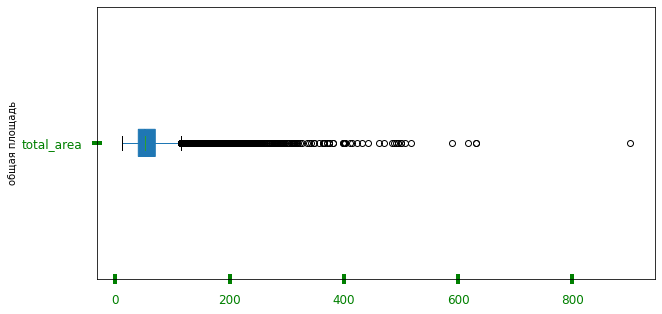

In [39]:
plt.figure(figsize =(10, 5))
data.boxplot('total_area', 
            notch=True, 
            sym="o", 
            vert=False,
            widths = 0.1, 
            patch_artist = True)
plt.ylabel('общая площадь')
plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 4,     #  Ширина делений
               color = 'g',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 12,    #  Размер подписи
               labelcolor = 'g'    #  Цвет подписи
               )

plt.grid()
plt.show()

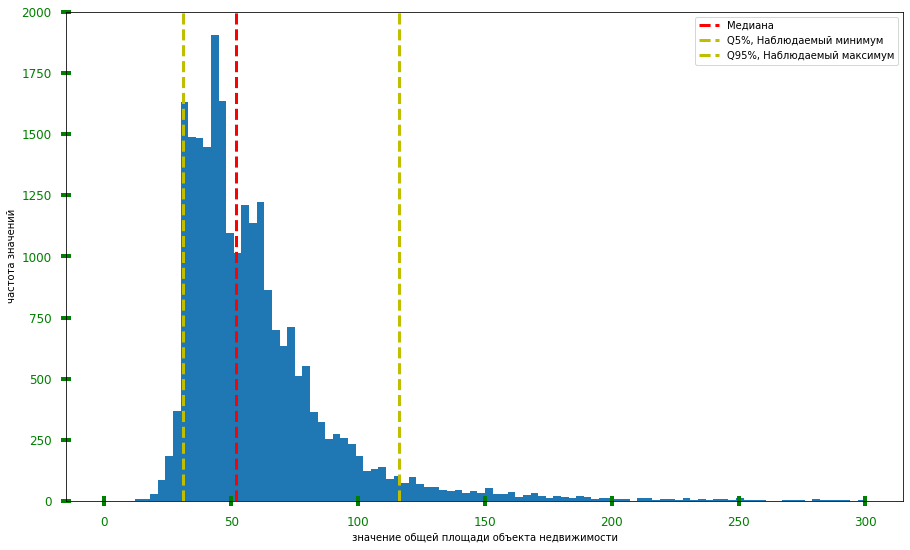

count   23565.000
mean       60.323
std        35.657
min        12.000
25%        40.000
50%        52.000
75%        69.700
max       900.000
Name: total_area, dtype: float64

In [40]:


data['total_area'].hist(bins=100, range=(0, 300), figsize=(15,9))
plt.xlabel('значение общей площади объекта недвижимости')
plt.ylabel('частота значений')
plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 4,     #  Ширина делений
               color = 'g',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 12,    #  Размер подписи
               labelcolor = 'g'    #  Цвет подписи
             )    #  Поворот подписей
plt.axvline(label= 'Медиана', x=data['total_area'].median(),
                linewidth=3, 
                color='red', 
                linestyle='--')
plt.axvline(label= 'Q5%, Наблюдаемый минимум', x=data['total_area'].quantile(.05),
                linewidth=3, 
                color='y', 
                linestyle='--')
plt.axvline(label= 'Q95%, Наблюдаемый максимум', x=data['total_area'].quantile(.95),
                linewidth=3, 
                color='y', 
                linestyle='--'
           )
plt.grid()
plt.legend()
plt.show()
data['total_area'].describe()

In [41]:
q75, q25 = np.percentile(data['total_area'], [75,25])
iqr = q75 - q25
min = q25 - (q25 +1.5*iqr)
max = q75 + 1.5*iqr
print('IQR: ', iqr)
print('Граница нижнего уса: ', min)
print('Граница верхнего уса: ', max)

IQR:  29.700000000000003
Граница нижнего уса:  -44.55000000000001
Граница верхнего уса:  114.25


Из графика видно, что большинство квартир имеет площадь от 40 до 69 кв.м. График имеет вид распределения Пуасона. Минимальное и максимальное значения, в принципе, соответствуют действительности.

Цена

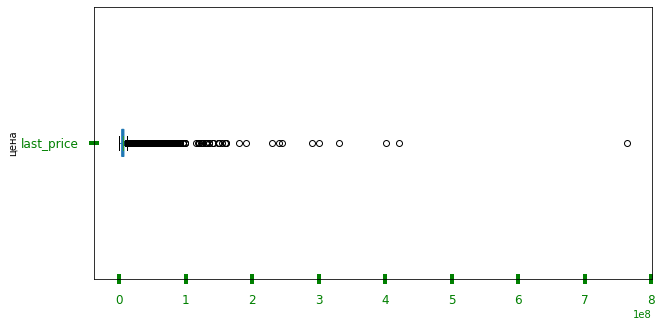

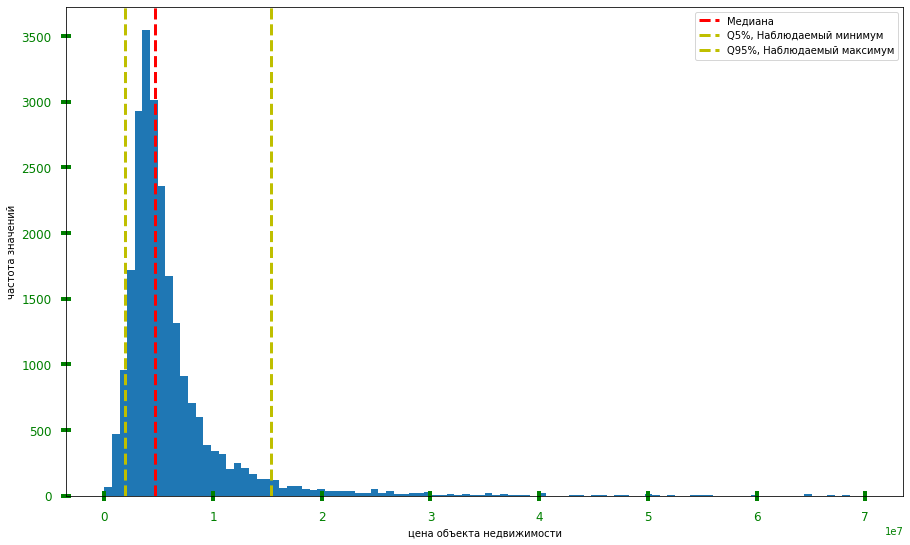

count       23565.000
mean      6540058.260
std      10910934.722
min         12190.000
25%       3400000.000
50%       4646000.000
75%       6790000.000
max     763000000.000
Name: last_price, dtype: float64

In [42]:
plt.figure(figsize =(10, 5))
data.boxplot('last_price', 
            notch=True, 
            sym="o", 
            vert=False,
            widths = 0.1, 
            patch_artist = True)
plt.ylabel('цена')
plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 4,     #  Ширина делений
               color = 'g',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 12,    #  Размер подписи
               labelcolor = 'g'    #  Цвет подписи
               )

plt.grid()
plt.show()
data['last_price'].hist(bins=100, range=(0, 70000000), figsize=(15,9))
plt.xlabel('цена объекта недвижимости')
plt.ylabel('частота значений')

plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 4,     #  Ширина делений
               color = 'g',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 12,    #  Размер подписи
               labelcolor = 'g'    #  Цвет подписи
             )    #  Поворот подписей
plt.axvline(label= 'Медиана', x=data['last_price'].median(),
                linewidth=3, 
                color='red', 
                linestyle='--')
plt.axvline(label= 'Q5%, Наблюдаемый минимум', x=data['last_price'].quantile(.05),
                linewidth=3, 
                color='y', 
                linestyle='--')
plt.axvline(label= 'Q95%, Наблюдаемый максимум', x=data['last_price'].quantile(.95),
                linewidth=3, 
                color='y', 
                linestyle='--'
           )

plt.grid()
plt.legend()
plt.show()
data['last_price'].describe()

In [43]:
q75, q25 = np.percentile(data['last_price'], [75,25])
iqr = q75 - q25
min = q25 - (q25 +1.5*iqr)
max = q75 + 1.5*iqr
print('IQR: ', iqr)
print('Граница нижнего уса: ', min)
print('Граница верхнего уса: ', max)

IQR:  3390000.0
Граница нижнего уса:  -5085000.0
Граница верхнего уса:  11875000.0


In [44]:
len(data[data['last_price'] > 11875000])

2046

График имеет вид нормального распределения. В основном цены меняютья от 3400 тыс. руб до 6790 тысю руб. Наблюдаем очень низкое минимальное значение, скорее всего пользователь ошибся и указал цену аренды а не продажи, или просто забыл дописать несколько нулей. Такое значение всего одно, можем его не учитывать.

Рассмотри число комнат, как тут обстоят дела?

In [45]:
data['rooms'].describe()

count   23565.000
mean        2.071
std         1.079
min         0.000
25%         1.000
50%         2.000
75%         3.000
max        19.000
Name: rooms, dtype: float64

Видим нулевые значения. Это явная ошибка изменим данные. С помощью уже созданной функции no_artefact.

In [46]:
len(data[data['rooms'] == 0])

194

In [47]:
data = no_artefact(data, 'rooms', 'total_area_group', 0, 20)


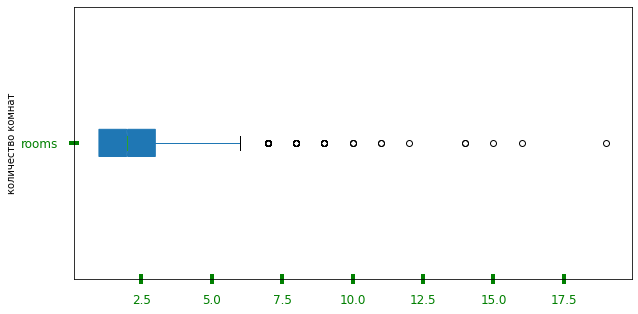

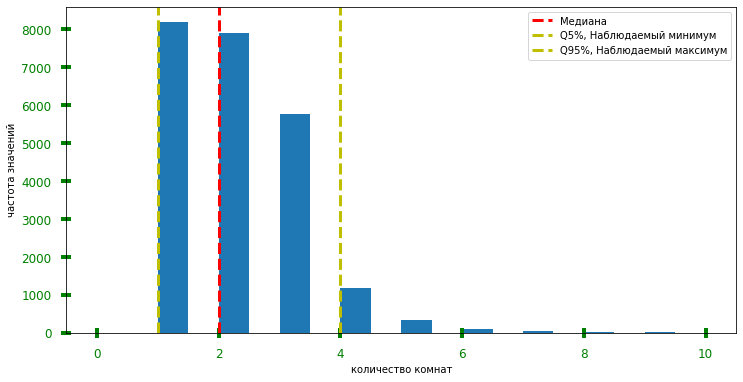

count   23565.000
mean        2.079
std         1.066
min         1.000
25%         1.000
50%         2.000
75%         3.000
max        19.000
Name: rooms, dtype: float64

In [48]:
plt.figure(figsize =(10, 5))
data.boxplot('rooms', 
            notch=True, 
            sym="o", 
            vert=False,
            widths = 0.1, 
            patch_artist = True)
plt.ylabel('количество комнат')
plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 4,     #  Ширина делений
               color = 'g',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 12,    #  Размер подписи
               labelcolor = 'g'    #  Цвет подписи
               )

plt.grid()
plt.show()

data['rooms'].hist(bins=20, range=(0, 10), figsize=(12,6))
plt.xlabel('количество комнат')
plt.ylabel('частота значений')

plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 4,     #  Ширина делений
               color = 'g',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 12,    #  Размер подписи
               labelcolor = 'g'    #  Цвет подписи
             )    #  Поворот подписей
plt.axvline(label= 'Медиана', x=data['rooms'].median(),
                linewidth=3, 
                color='red', 
                linestyle='--')
plt.axvline(label= 'Q5%, Наблюдаемый минимум', x=data['rooms'].quantile(.05),
                linewidth=3, 
                color='y', 
                linestyle='--')
plt.axvline(label= 'Q95%, Наблюдаемый максимум', x=data['rooms'].quantile(.95),
                linewidth=3, 
                color='y', 
                linestyle='--'
           )
plt.grid()
plt.legend()
plt.show()
data['rooms'].describe()


In [49]:
q75, q25 = np.percentile(data['rooms'], [75,25])
iqr = q75 - q25
min = q25 - (q25 +1.5*iqr)
max = q75 + 1.5*iqr
print('IQR: ', iqr)
print('Граница нижнего уса: ', min)
print('Граница верхнего уса: ', max)

IQR:  2.0
Граница нижнего уса:  -3.0
Граница верхнего уса:  6.0


Из гарфика видим что основное количество комнат от 1 до 3. Минимальное значение мы заменили. Максимальное думаю не нужно, тут всякое может быть )) 19 комнат это не предел.

Поссмотрим на высоту потолков. Так как мы уже убирали артефакты в этом столбце, думаю сюрпризов не будет.

Видим что основная высота потолков колеблется от 2,2 метра до 2,75 метра. Минимальные и максимальные значения соответствуют здравому смыслу.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Андрей, так держать! Типы графиков выбраны верно, согласна с твоей интерпретацией полученных распределений.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
        
Андрей, если ты используешь визуализацию в анализе, очень важно уделять внимание ее оформлению: стоит добавлять общие заголовки, названия осей на русском языке. Технические строчки типа `<matplotlib.axes._subplots.AxesSubplot at 0x7f2e09dbbd90>` можно убрать с помощью метода `plt.show()` или с помощью `;`
        
Уделять время оформлению графиков уже в первых проектах важно, потому что с их усложнением, будет усложняться и визуализация, и в этих случаях без корректного оформления будет очень сложно понять, о чем визуализация и зачем она. Постарайся подкорректировать графики в проекте🙄

<div class="alert alert-info">
    <h2> Комментарий студента <a class="tocSkip"> </h2>
    
        
Дополнил графики, теперь информация более понятна.

<div class="alert alert-success">
<h2> Комментарий ревьюера: вторая итерация ревью <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Андрей, отличная работа! У тебя получилось очень информативные графики, здорово, что попробовал новые методы, выглядит круто! Также вижу, что ты попытался применить IQR, все получилось!

Мы посмотрели на основные параметры объекта недвижимости, которые могут повлиять на цену квадратного метра. Почистили артефакты. Посмотрим как долго продаются квартиры.
Изучим время продажи квартиры. Пострим гистограмму. Посчитаем среднее и медиану. Опишим, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

In [50]:

print('Среднее время продажи объекта недвижимости: {:.1f} дней.'.format(data['days_exposition'].mean()))
print(' ')
print('Медиана времени прадажи объекта недвижимости: {} дней.'.format(data['days_exposition'].median()))

Среднее время продажи объекта недвижимости: 180.7 дней.
 
Медиана времени прадажи объекта недвижимости: 95.0 дней.


Медиана очень отличается от среднего значения, скорее всего это связанно с недостоверными значениями в столбце.

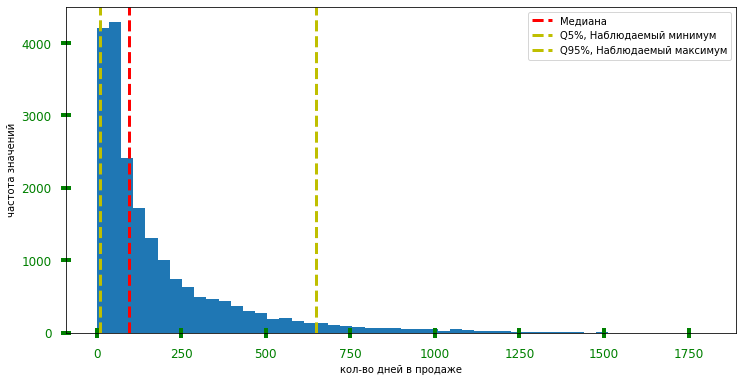

count   20394.000
mean      180.741
std       219.733
min         1.000
25%        45.000
50%        95.000
75%       231.000
max      1580.000
Name: days_exposition, dtype: float64

In [51]:
data['days_exposition'].hist(bins=50, range=(0, 1800), figsize=(12,6))
plt.xlabel('кол-во дней в продаже')
plt.ylabel('частота значений')

plt.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 4,     #  Ширина делений
               color = 'g',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 12,    #  Размер подписи
               labelcolor = 'g'    #  Цвет подписи
             )    #  Поворот подписей
plt.axvline(label= 'Медиана', x=data['days_exposition'].median(),
                linewidth=3, 
                color='red', 
                linestyle='--')
plt.axvline(label= 'Q5%, Наблюдаемый минимум', x=data['days_exposition'].quantile(.05),
                linewidth=3, 
                color='y', 
                linestyle='--')
plt.axvline(label= 'Q95%, Наблюдаемый максимум', x=data['days_exposition'].quantile(.95),
                linewidth=3, 
                color='y', 
                linestyle='--'
           )
plt.grid()
plt.legend()

plt.show()
data['days_exposition'].describe()

In [52]:
len(data[data['days_exposition'] > 365])

3042

Видим, что в основном люди продают объект недвижимости за 45 - 198 дней (1,5 мес до 6,5 мес). Но есть и объявления которые висели 4,3 года. Даже объявлений с размещением более года - 3025 шт. Может быть пользователи просто забыли снять объявления с продажи или все таки это реальные объявления?
Посмотрим диаграмму размаха, что она нам скажет.

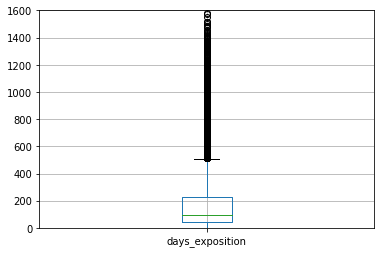

In [53]:
plt.ylim(0, 1600)
data.boxplot('days_exposition')

Из диаграмы размаха мы видим, что в основном объявление находится в продаже 96 дней. Посмотрим на усы диаграммы. Быстрой считаеться продажа за 1 - 45 дней, долгой считаеться продажа от 430 дней. Что, в принципе, соответствует правде. 1,5 года достаточно чтобы найти покупателя и продать картиру. Необходимо убрать редкие и выбивающиеся значения. Предлагаю считать значение 600 дней как максимум, остальные значения достаточно редки и слишком превышают нормальные значения.

In [54]:
len(data[data['days_exposition'] > 600])

1193

Чтобы не потерять данные (хоть и количество дней продажи завышено, но остальные параметра квартир достоверны и пригодятся нам) применим функцию no_artefact заменим все значения выше 600 на медианные значения объявлений с похожей общей площадью.

In [55]:
data = no_artefact(data, 'days_exposition', 'total_area_group', 0, 600)

In [56]:
len(data[data['days_exposition'] > 600])

0

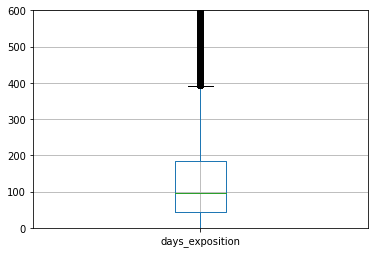

count   20394.000
mean      139.320
std       132.855
min         1.000
25%        45.000
50%        95.000
75%       184.000
max       600.000
Name: days_exposition, dtype: float64

In [57]:
plt.ylim(0, 600)
data.boxplot('days_exposition')
plt.show()
data['days_exposition'].describe()

Мы убрали редкие и выбивающиеся значения, благодаря этому средние значение уменьшилось до 134 дней. 
Данные очищены. 
Теперь ответим на следующие вопросы.
Какие факторы больше всего влияют на стоимость квартиры? Зависит ли цена от площади, числа комнат, удалённости от центра. Есть ли, зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также посмотрим зависимость от даты размещения: дня недели, месяца и года.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
    
Из инструкции это может быть не так ясно, но в целом задача по удалению выбросов касается колонок площадь, цена, число комнат, высота потолков, анализ days_exposition (дня размещения объявления о продаже недвижимости) стоит, скорее, особняком, в случае этой колонки просто важно изучить время продажи квартиры. Данные в этой колонке чувствительные, и лучше проанализировать весь их набор, не удаляя "выбросы"
    
    
Что касается выбросов в этих колонках, я бы посоветовала добавить анализ выбросов (и их удаление) с помощью cпециальных методов, например, IQR (почти то же самое, что диаграмма ящик с усами, но дает тебе точные границы в цифрах, по которым нужно "отрезать" данные), z-статистика (метод только для данных, которые имеют распределение, походящее на Гауссово или нормальное распределение). Подробнее о нметодах по ссылкам ниже.
    
Полезные статьи по методам работы с выбросами на русском и английском языках:
    
https://www.machinelearningmastery.ru/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623/
    
https://proglib.io/p/moem-dataset-rukovodstvo-po-ochistke-dannyh-v-python-2020-03-27
    
(эти на английском)
    
https://statisticsbyjim.com/basics/outliers/
    
https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/
    
https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
        
Важно при этом понимать, что стат методы тоже могут "отработать" на данных не совсем адекватно, т.е. корректно с точки зрения механики их работы, но не корректно с точки зрения здравого смысла и специфики данных, с которыми ты работаешь. Поэтому всегда важно подключать к применяемым методам экспертную оценку (наверно, ты лучше понимаешь, что бывают потолки 3 метра, например, а вот стат метод может посчитать это за выброс и удалить в зависимости от набора данных, которые ему скармливаются).
        
P.S. Не забудь про оформление графиков, также рекомендую построить диаграммы ящик с усами для интересующих нас переменных.


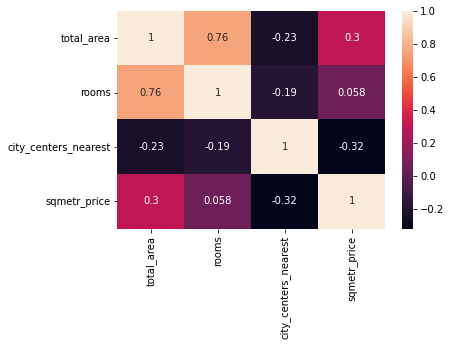

In [58]:
stat = data.loc[:, ['total_area', 'rooms', 'city_centers_nearest', 'sqmetr_price']]

corrMatrix = stat.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

Мы построили матрицу корреляции, по данным которой очевидной взамосвязи между ценой квадратно метра, общей площадью, количеством комнат, удаленностью от центра нет. Может быть есть связь между ценой кв.метра и этажом квартиры?

Создадим сводную таблицу с нименоваанием этажа и средней ценой за кв.метр.

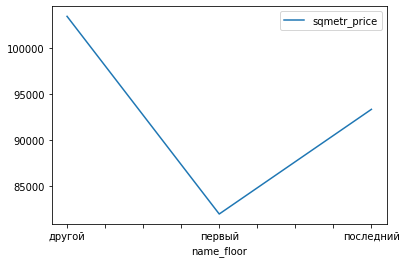

In [59]:
data.pivot_table(index='name_floor', values='sqmetr_price').plot()
plt.show()

Видим, что в среднем самую низкую цену за квадратный метр, дают за квартиры на первом этаже, затем на последнем этаже. Больше всего платят за квадратный метр квартиры ни на первом и ни на последнем этаже. Посмотрим как средняя цена за квадрат зависит от дня недели, месяца и года подачи объявления.

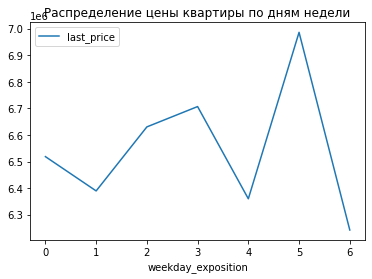

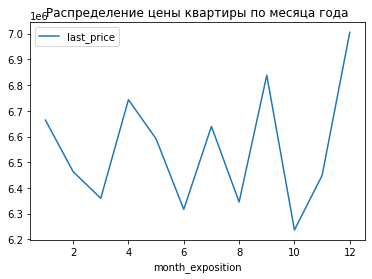

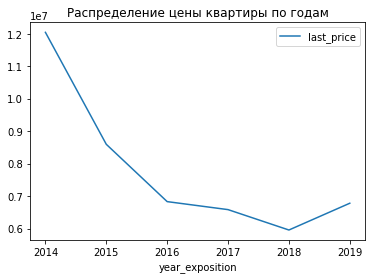

In [60]:
data.pivot_table(index='weekday_exposition', values='last_price').plot(title='Распределение цены квартиры по дням недели')
data.pivot_table(index='month_exposition', values='last_price').plot(title='Распределение цены квартиры по месяца года')
data.pivot_table(index='year_exposition', values='last_price').plot(title='Распределение цены квартиры по годам')
plt.show()


Что видим в этих графиках. Объявления с самой низкой ценой обычно подают в воскресенье, а самой высокой ценой в четверг. Если смотреть по месяцам, в апреле больше всех объявлений с самой высокой средней ценой за квадратный метр, в июне и октябре подаются объявления с самой низкой ценой за квадратный метр. Намного интереснее посмотреть на цену за кв.метр в разрере последних лет. Видно, что цена снижалась до 2017 годаб в 2018 незначительный рост, можно было хорошо съекономить купив квартиру в 2017 или 2018 году. С 2019 году видим значительный рост цены кв.метр до уровня 2015 года.
Но вернемся к нашему исследованию. Выберем 10 населённых пунктов с наибольшим числом объявлений. Посчитаем среднюю цену квадратного метра в этих населённых пунктах. Выделим среди них населённые пункты с самой высокой и низкой стоимостью жилья.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Андрей, в целом, я согласна с логикой твоих действий на данном этапе анализа, ты корректно проинтерпретировал результаты своей работы и графики!

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
        
Что могу посоветовать для улучшения работы:
        
1) возможно, для количественных переменных было бы удобнее выводить коэффициенты корреляции в единой корреляционной таблице или использовать график типа `heatmap` 
        
https://datatofish.com/correlation-matrix-pandas/ (построение корреляционной матрицы с помощью Python)

        
https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas (полезный тред на Stackoverflow, очень полезный ресурс для кодеров, советую, с помощью него можно решить практически все проблемы, которые возникают у тебя при работе с кодом)
        
https://likegeeks.com/python-correlation-matrix/ (еще один туториал)

2) корреляцию лучше посчитать для количественных переменных, для категориальных же адекватнее использовать графический метод (столбчатые диаграммы для анализа категорий этажности, дня, месяца и года подачи объявления о продаже квартиры, количества комнат) Сейчас ты используешь линейные графики для анализа этих факторов, в этом нет ошибки, но, кажется, что визуально этот тип графика менее подходит для анализа такого рода переменных.
    
3) графики лучше дооформить!

<div class="alert alert-success">
<h2> Комментарий ревьюера: вторая итерация ревью <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Ок, у тебя получилось построить тепловую карту, выглядит здорово!

In [61]:
data_1 = data['locality_name'].value_counts().head(10)
data10 = data.query('locality_name in @data_1.index')
data10['locality_name'].value_counts()

санкт-петербург      15651
поселок мурино         552
поселок шушары         439
всеволожск             398
пушкин                 369
колпино                338
поселок парголово      327
гатчина                307
деревня кудрово        299
выборг                 237
Name: locality_name, dtype: int64

Это наши ТОП-10. На первом месте, ожидаемо, Санкт-Петербург. Найдем Среднюю цену кв.метра в этих населенных пунктах.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Топ - 10 населенных пунктов по количеству объявлений определен верно!
    

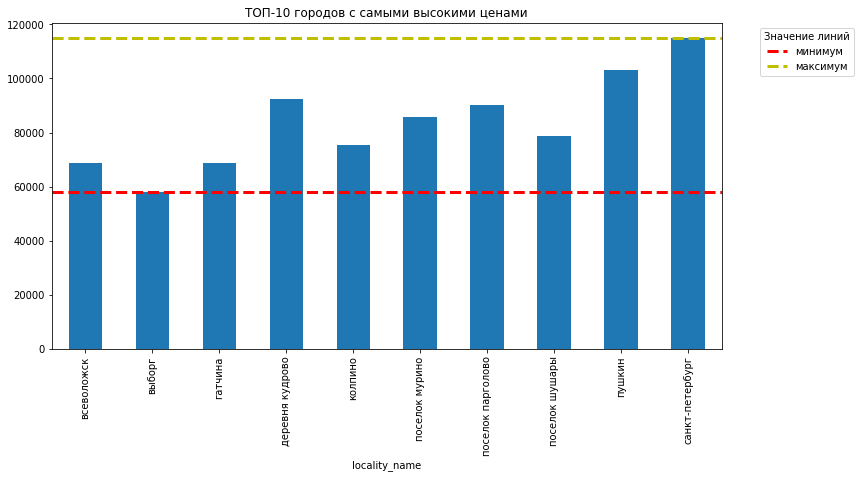

In [62]:
d2 = data10.pivot_table(index ='locality_name', values='sqmetr_price').reset_index()
d2.plot(x= 'locality_name', y='sqmetr_price', kind='bar', figsize =(12, 6), title= 'ТОП-10 городов с самыми высокими ценами', legend = True)
x1 = plt.axhline(y= d2['sqmetr_price'].min(),
           linewidth=3, 
                color='r', 
                linestyle='--',
           label = 'минимум')
x2 = plt.axhline(y= d2['sqmetr_price'].max(),
           linewidth=3, 
                color='y', 
                linestyle='--',
           label = 'максимум')
plt.legend(handles=[x1, x2], title='Значение линий', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title= 'ТОП-10 городов с самыми высокими ценами'
plt.show()

Из графика видим. Набольшая цена кв.метра - Санкт петербург, наименьшая - выборг.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Да, все так!
    

Изучим предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделим квартиры в Санкт-Петербурге. Наша задача — выяснить, какая область входит в центр. Создадим столбец с расстоянием до центра в километрах: округлим до целых значений. После этого посчитаем среднюю цену для каждого километра. Построим график: он должен показывать, как цена зависит от удалённости от центра. Определим границу, где график сильно меняется — это и будет центральная зона.


In [63]:

data1 = data[data['locality_name'] == 'санкт-петербург']
data1['city_centers_nearest_km'] = data1['city_centers_nearest'] / 1000
data1['city_centers_nearest_km'] = data1['city_centers_nearest_km'].apply(np.floor)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


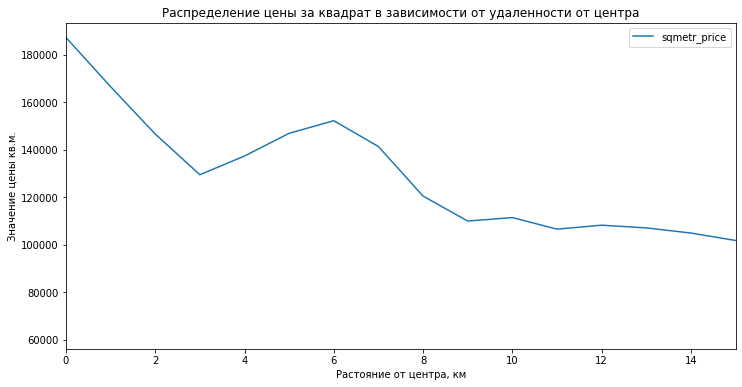

In [64]:
X_1 = data1.pivot_table(index='city_centers_nearest_km', values='sqmetr_price', aggfunc='mean').reset_index()
X_1.plot(x= 'city_centers_nearest_km', y='sqmetr_price', kind='line',  figsize =(12, 6), title= 'Распределение цены за квадрат в зависимости от удаленности от центра', xlim=(0, 15))
plt.xlabel('Растояние от центра, км')
plt.ylabel('Значение цены кв.м.')
plt.show()

Наблюдаем резкое падение цены квадратного метра после 7-8 км. Следовательно центром можно считать область радиусом 10 км. от центра.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
        
Я бы скорее выделила в качестве зоны центра границу в 7-8 км. Пока твой график выглядит не очень информативно, попробуй поменять его тип и поработать над читабельностью (здесь также можно попробовать использоватьстолбчатую диаграмму)
График может выглядеть примерно вот так:        
![image.png](attachment:image.png)

<div class="alert alert-success">
<h2> Комментарий ревьюера: вторая итерация ревью <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Хорошо, что удалось доработать график, теперь он выглядит более информативно!

Затем выделим сегмент квартир в центре. Проанализируем эту территорию и изучим следующие параметры: площадь, цена, число комнат, высота потолков. Также выделим факторы, которые влияют на стоимость квартиры (этаж, удалённость от центра, дата размещения объявления). Сделаем выводы. Отличаются ли они от общих выводов по всему городу?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


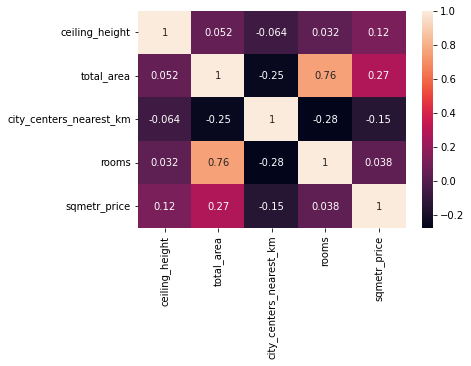

In [65]:
data_cen = data1.query('city_centers_nearest_km < 10')
data_cen['city_centers_nearest_km'] = data_cen['city_centers_nearest_km'].apply(np.floor)
data_cen1 = data_cen.loc[:, ['ceiling_height', 'total_area', 'city_centers_nearest_km', 'rooms', 'sqmetr_price']]
corrMatrix = data_cen1.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

Между ценой за квадратный метр, общей площадью, количество комнат, и расстоянием от центра так же как и по всем населенным пунктам взаимосвязи нет. Рассмотрим такие параметры как этаж, время размещения объявления.

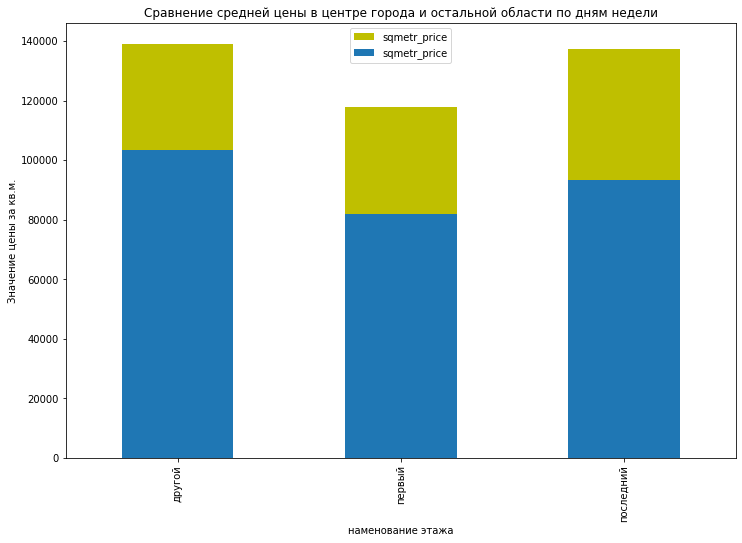

In [66]:
ax = data_cen.pivot_table(index='name_floor', values='sqmetr_price').plot(kind='bar', title= 'Данные по Санкт-Петербургу', color='y')
d = data.pivot_table(index='name_floor', values='sqmetr_price').plot(kind='bar', title= 'Сравнение средней цены в центре города и остальной области по дням недели', ax=ax, figsize=(12,8))
plt.xlabel('наменование этажа')
plt.ylabel('Значение цены за кв.м.')
plt.show()

Мы видим что, квартиры на первом этаже так же стоят дешевле чем на остальных этажах. Снижение цены на последние этажи отсутствует.

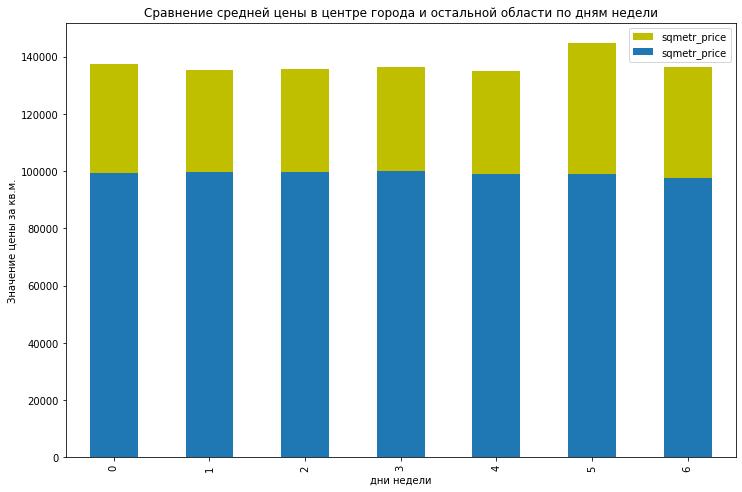

In [67]:
ax = data_cen.pivot_table(index='weekday_exposition', values='sqmetr_price').plot(kind='bar', title= 'Данные по Санкт-Петербургу', color='y')
d = data.pivot_table(index='weekday_exposition', values='sqmetr_price').plot(kind='bar', title= 'Сравнение средней цены в центре города и остальной области по дням недели', ax=ax, figsize=(12,8))
plt.xlabel('дни недели')
plt.ylabel('Значение цены за кв.м.')
plt.show()

Посмотрев данные по дням недели, можно сделать вывод, что ярко выраженного минимума нет, все дни кроме субботы примерно равны. В субботу пользователи подают объявления на продажу квартир.с самым дорогим квадратным метром.

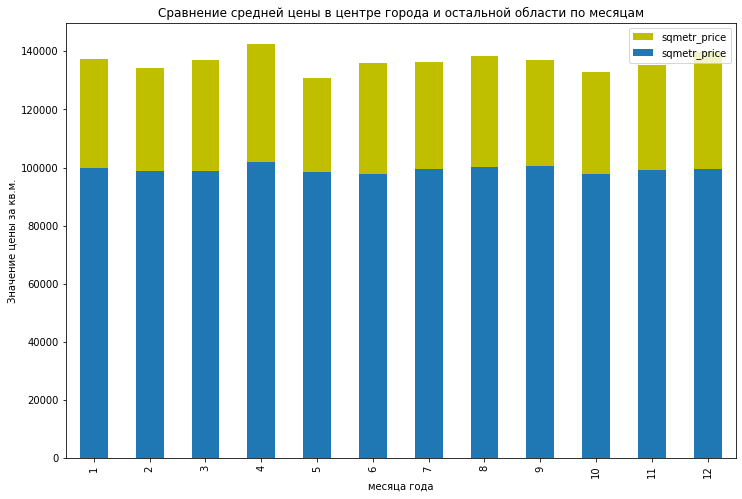

In [68]:

ax = data_cen.pivot_table(index='month_exposition', values='sqmetr_price').plot(kind='bar', title= 'Данные по Санкт-Петербургу', color='y')
d = data.pivot_table(index='month_exposition', values='sqmetr_price').plot(kind='bar', title= 'Сравнение средней цены в центре города и остальной области по месяцам', ax=ax, figsize=(12,8))
plt.xlabel('месяца года')
plt.ylabel('Значение цены за кв.м.')
plt.show()

Данные о размещении объявлений по месяцом приблизительно равны. Разницы между пригородом и мегаполисом нет.

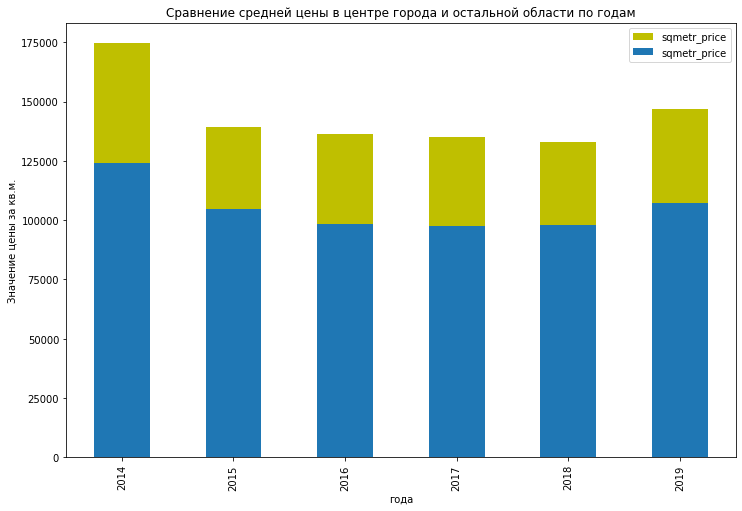

In [69]:
ax = data_cen.pivot_table(index='year_exposition', values='sqmetr_price').plot(kind='bar', title= 'Данные по Санкт-Петербургу', color='y')
d = data.pivot_table(index='year_exposition', values='sqmetr_price').plot(kind='bar', title= 'Сравнение средней цены в центре города и остальной области по годам', ax=ax, figsize=(12,8))
plt.xlabel('года')
plt.ylabel('Значение цены за кв.м.')
plt.show()

Данные по годам так же отличаються незначительно.

### Вывод


Мы изучили параметры объекта недвижости которые могут повлиять цену квадратного метра. Рассмотрели эти параметры в отдельности и постарались определить взаимосвязь между ними и ценой квадратного метра. Определили центр мегаполиса и рассмотрели теже параметры квартир но уже расположенных в центре города. Исследование не выявило явной взаимосвязи между параметрами. Странно но, даже корреляция между ценой квадратного метра и удаления от центра всего: - 0.318. 

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Да, в целом верно, что ты пытаешься сравнить данные по всему СПб с данными по центру СПб, так анализ выглядит нагляднее!

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip">  </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
        
Андрей, на этом шаге все те же рекомендации, что и на этапе анализа всего рынка жилья: удели внимание графикам, попробуй создать единую корреляционную матрицу (которая тепловая карта), для категориальных признаков лучше построить графики barplot или boxplot (вот например линейные графики для дня, месяца и года размещения объявления о продаже жилья не слишком информативны)

<div class="alert alert-success">
<h2> Комментарий ревьюера: вторая итерация ревью <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
У тебя получилось доработать этот шаг, визуализация выглядит отлично, отдельный плюс за оформление!

## Общий вывод

Была проделана большая работа. Нам были предоставлны данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно было научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. Для этого была проведена предоработка данных. Были определены пропуски и аномальные данные которые мы с помощью функций no_NAN и no_artefact, переписали на медианные значения. Так же изменили типы данных столбцов необходимых нам в дальнейших расчетах. Были дабавлены такие парметры как цена квадратного метра, день, месяц и год подачи объявления. Мы подробно рассмотрели данные из стобца days_exposition — сколько дней было размещено объявление. С помощью диаграмы размаха определили редкие и выбивающиеся значения. Их так же заменили на медианные значения. Затем постарались определить корреляцию меджу ценой квадратного метра и таким параметрами как - площадь квартиры, количество комнат, высота потолков, этаж квартиры, удаление от центра. К сожалению явной взамосвязи я не нашел. даже корреляция между ценой квадратного метра и удаления от центра всего: - 0.318. Затем были рассмотрены объявления картир из Санкт-петербурга. Рассмотрев взамосвязь между ценой квадратно метра и расположением квартиры от центра города мы опредлелили область центра города - 10 км. Затем постарались определить корреляцию меджу ценой квадратного метра и таким параметрами как - площадь квартиры, количество комнат, высота потолков, этаж квартиры, удаление от центра, но уже в ценре города. К сожалению явной связи так же нет. Подводя итог, можно сказать либо мои исследования не верны, либо отсутсвие связи это сам по себе результат. т.е. обяъявления имеющие явную связь между вышеказанными параметрами могут быть аномалиями или мошейнической деятельностью.

<div class="alert alert-info">
    <h2> Комментарий студента <a class="tocSkip"> </h2>
    
        
Обобщив данные можно сказать, что мы определили папаметры "нормальной" квартиры - общая площать не больше 114 кв.м., ценой не больше 6 790 000 руб., не больше 6 комнат, такая квартира будет продана не дольше чем за 435 дней. Так же стоимость объекта недвижимости зависит только от удаленности от центра города.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>

Андрей, если ты вспомнишь инструкцию к проекту, то основная цель звучит так: 
    
`В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.`
    
Поэтому в итоговом выводе важно не просто суммировать свои действия в рамках реализации анализа, а также дать рекомендации заказчику. Попробуй подумать, какие это могут быть рекомендации, и сформулировав их, добавь в итоговый вывод по проекту.

<div class="alert alert-success">
<h2> Комментарий ревьюера: вторая итерация ревью <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Хорошо, теперь итоговый вывод в большей степени ориентирован на заказчика и основную задачу исследования, так держать!

<div style="border:solid Chocolate 2px; padding: 40px">

**Общий вывод по проекту**

Андрей, спасибо за твой проект! Ты приложил много усилий, чтобы довести его до конца, фактически все задачи в рамках проекта у тебя получились, проделана огромная работа, и это видно невооруженным глазом, ты большой молодец! Есть несколько важных моментов, которые я отметила и которые можно было бы улучшить, подсказки ты найдешь в моих комментариях. 

**Отмечу отдельные положительные моменты проекта🙂**:
 
* На разных шагах проекта ты предлагал очень интересные решения и методы для их реализации. Хорошая работа!
* Здорово, что ты использовал автоматизацию для выполнения задач, писал свои функции и циклы, так держать!
* Ты использовал самые разные методы для работы с данными, все получилось!
* Ты активно использовал визуализацию, хорошо, что ты не избегаешь этого инструмента анализа!

**На что стоит обратить внимание🤓**:
    
* Удели чуть больше внимания визуализации: в некоторых случаях графикам не хватает оформления, можно попробовать сделать визуализацию более информативной!
* Выбросы в колонке days_exposition удалять не стоит, а вот поработать над аномальными значениями в других колонках - стоит:)
* Важно доработать итоговый вывод!
* Корреляционный анализ стоит проводить для количественных переменных, для категориальных лучше построить графики.
* Остальные рекомендации ты найдешь в моих комментариях!


**Желаю удачи и жду твой проект на повторное ревью!**😉
    
![gif](https://media.giphy.com/media/kVaj8JXJcDsqs/giphy.gif)

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

<div style="border:solid Chocolate 2px; padding: 40px">

**Общий вывод по проекту:  вторая итерация ревью**

Андрей, спасибо, что прислал проект с доработками! Тебе удалось значительно улучшить проект, особенно в части визуализации, у тебя все отлично получается, дальше - больше и лучше!
Спешу тебе сообщить, что твой проект принят, и ты можешь перейти на следующий спринт!
    
**Желаю тебе крутых и интересных проектов на следующих спринтах**😉
    
![gif](https://media.giphy.com/media/l3vR76o4wmQ4aIrV6/giphy.gif)

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод